# Normalization

#### 1. Importing the libraries

In [1]:
import os
import numpy as np
from datetime import datetime, date, timedelta
import tensorflow as tf
from tensorflow import keras
from keras.layers import *


#### 2. Loading the data into training and validation set

In [2]:
train = keras.utils.image_dataset_from_directory(
    directory = './dataset',
    validation_split=0.1,
    subset='training',
    seed=123,
    labels = 'inferred',
    label_mode = 'int',
    image_size = (128, 128),
)

Found 17125 files belonging to 20 classes.
Using 15413 files for training.


In [3]:
val = keras.utils.image_dataset_from_directory(
    directory = './dataset',
    validation_split=0.2,
    subset='validation',
    seed=123,
    labels = 'inferred',
    label_mode = 'int',
    image_size = (128, 128),
)

Found 17125 files belonging to 20 classes.
Using 3425 files for validation.


#### 3. Normalizing the image dataset

In [4]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_norm = train.map(lambda x, y: (normalization_layer(x), y))
val_norm = val.map(lambda x, y: (normalization_layer(x), y))

#### 4. Initializing the model architechture

In [9]:
model = tf.keras.Sequential([
    Conv2D(32, kernel_size=(5,5), padding='valid', activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(pool_size=(2,2), padding='valid'),

    Conv2D(64, kernel_size=(5,5), padding='valid', activation='relu'),
    MaxPooling2D(pool_size=(2,2), padding='valid'),

    Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'),
    MaxPooling2D(pool_size=(2,2), padding='valid'),
    Dropout(rate=0.3),
    
    Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'),
    MaxPooling2D(pool_size=(2,2), padding='valid'),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(rate=0.2),
    Dense(64, activation='relu'),
    Dense(20, activation='sigmoid')
])

In [ ]:
model.summary()

In [ ]:
# Run to clear the learned weights

tf.keras.backend.clear_session()

In [ ]:
# Run to load previous weights

today = date.today()
yesterday = today - timedelta(days=1)

path='model_checkpoints/' + yesterday.strftime("%D").replace('/', '_') + '/model.pkl'

model.load_weights(path)

In [10]:
class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('accuracy') > 0.85):
			print(logs)
			print("\nReached the required accuracy, so stopping training!!")
			self.model.stop_training = True

callback = myCallback()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_norm, epochs=50, validation_data=val_norm, callbacks=[callback])

Epoch 1/50
482/482 [==============================] - 24s 47ms/step - loss: 2.4063 - accuracy: 0.3999 - val_loss: 2.3872 - val_accuracy: 0.4058
Epoch 2/50
482/482 [==============================] - 17s 36ms/step - loss: 2.3350 - accuracy: 0.4015 - val_loss: 2.2733 - val_accuracy: 0.4058
Epoch 3/50
482/482 [==============================] - 18s 36ms/step - loss: 2.2185 - accuracy: 0.4050 - val_loss: 2.1084 - val_accuracy: 0.4210
Epoch 4/50
482/482 [==============================] - 18s 37ms/step - loss: 2.1190 - accuracy: 0.4099 - val_loss: 2.0309 - val_accuracy: 0.4359
Epoch 5/50
482/482 [==============================] - 18s 37ms/step - loss: 2.0380 - accuracy: 0.4218 - val_loss: 1.9129 - val_accuracy: 0.4531
Epoch 6/50
482/482 [==============================] - 19s 39ms/step - loss: 1.9672 - accuracy: 0.4362 - val_loss: 1.9233 - val_accuracy: 0.4593
Epoch 7/50
482/482 [==============================] - 19s 38ms/step - loss: 1.8889 - accuracy: 0.4491 - val_loss: 1.7891 - val_accuracy:

In [11]:
from datetime import datetime

date = datetime.now().strftime("%D")
date=date.replace('/', '_')

path='model_checkpoints/'+date+'/model.pkl'
model.save_weights(path)

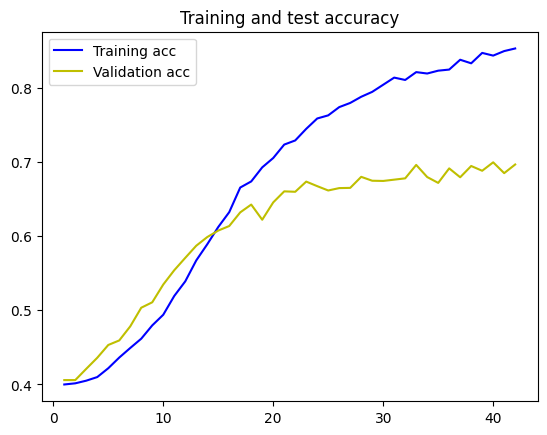

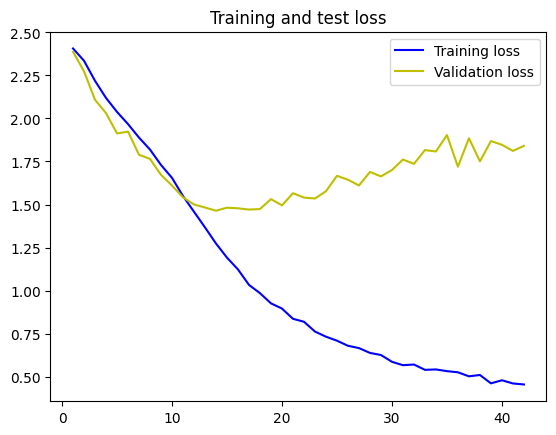

In [12]:
accuracy = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

import matplotlib.pyplot as plt

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'b', label='Training acc')
plt.plot(epochs, val_accuracy, 'y', label='Validation acc')
plt.title('Training and test accuracy')
plt.legend()
plt.savefig('model_checkpoints/'+date+'/accuracy.png', bbox_inches='tight')
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and test loss')
plt.legend()
plt.savefig('model_checkpoints/'+date+'/loss.png', bbox_inches='tight')
plt.show()


# plt.savefig('foo.pdf')

In [ ]:
temp = np.array([history.history['accuracy'], history.history['loss'], history.history['val_accuracy'], history.history['val_loss']])
np.save('model_checkpoints/'+date+'/metrics.npy', temp)